In [1]:
from numpy.polynomial import polynomial as P
import matplotlib.pyplot as plt
import xarray as xr

import data_catalog
import tseries_mod
import esmlab_wrap
from utils import repl_coord, smooth, da_normalize, da_w_lags
from utils_plot import plot_1var

In [2]:
data_catalog.set_catalog('experiments')

active catalog: experiments


In [3]:
varnames = {'atm': ['TS', 'SFCO2_LND'],
            'lnd': ['GPP', 'NPP', 'AR', 'TOTVEGC', 'HR', 'TOTSOMC', 'ER'],
           }

ds_dict = {}
for component in varnames:
    ds_dict[component] = {}

for experiment in ['piControl', 'esm-piControl']:
    for component in varnames:
        ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment)

for experiment in ['piControl-cmip5', 'esm-piControl-cmip5']:
    for component in varnames:
        if component == 'atm':
            ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment, stream='cam2.h0')
        else:
            ds_dict[component][experiment] = tseries_mod.tseries_get_vars(varnames[component], component, experiment)

legend_dict = {'piControl': 'piControl, CESM2',
               'esm-piControl': 'esm-piControl, CESM2',
               'piControl-cmip5': 'piControl, CESM1(BGC)',
               'esm-piControl-cmip5': 'esm-piControl, CESM1(BGC)',
              }


In [4]:
def corr_anal(varname_pair, expr_list, component_pair=('atm', 'atm'), region_x='Global', region_y_list=['Global'], ylim=None):
    max_lag = 30
    varname_x, varname_y = varname_pair
    component_x, component_y = component_pair
    for region_y in region_y_list:
        print(f'varname_x={varname_x}, region_x={region_x}, varname_y={varname_y}, region_y={region_y}')
        plot_dict = {}
        for experiment in expr_list:
            # construct da_x
            tb_name = ds_dict[component_x][experiment]['time'].attrs['bounds']
            ds_x = esmlab_wrap.compute_mon_anomaly(ds_dict[component_x][experiment][[tb_name, varname_x]])
            iseldict = {}
            if 'lev' in ds_x[varname_x].dims:
                iseldict['lev'] = -1
            da_x = ds_x[varname_x].sel(region=region_x).isel(iseldict)

            # construct da_y
            # replace time with ds_x's time, so that vars are aligned in corr computation
            tb_name = ds_dict[component_y][experiment]['time'].attrs['bounds']
            ds_tmp = repl_coord('time', ds_x, ds_dict[component_y][experiment][[tb_name, varname_y]])
            ds_y = esmlab_wrap.compute_mon_anomaly(ds_tmp)
            ds_y = repl_coord('time', ds_x, ds_y)
            iseldict = {}
            if 'lev' in ds_y[varname_y].dims:
                iseldict['lev'] = -1
            da_y = ds_y[varname_y].sel(region=region_y).isel(iseldict)
            
            # apply smoothing to da_x and da_y
            for da in [da_x, da_y]:
                da_sm, smooth_edge_len = smooth(da, filter_len=10*12, ret_edge_len=True)
                da -= da_sm

            # compute lagged correlation between varname_x and varname_y
            da_x_norm = da_normalize(da_x)
            da_y_norm = da_normalize(da_y)
            da_xy_corr = (da_x_norm * da_w_lags(da_y_norm, max_lag=max_lag)).mean('time')
            da_xy_corr.attrs['long_name'] = ' '.join(['lagged correlation between',
                                                      varname_x, 'and', varname_y])

            # compute lagged regression coefficient between varname_x and varname_y
            da_y_w_lags = da_w_lags(da_y, max_lag=max_lag)
            edge_len = smooth_edge_len + max_lag
            pf = P.polyfit(da_x.values[edge_len:-edge_len],
                           da_y_w_lags.values[:,edge_len:-edge_len].transpose(), 1)
            da_slope = da_xy_corr.copy()
            da_slope.values = pf[1,:]
            da_slope.attrs['units'] = f'({da_y.attrs["units"]})/({da_x.attrs["units"]})'
            da_slope.attrs['long_name'] = ' '.join(['lagged regression slope between',
                                                   varname_x, 'and', varname_y])
            
            plot_dict[experiment] = xr.Dataset({'xy_corr': da_xy_corr, 'slope': da_slope})

        plot_1var('xy_corr', [plot_dict[expr] for expr in expr_list],
                  [legend_dict[expr] for expr in expr_list], figsize=(7.5,4.5))
        plot_1var('slope', [plot_dict[expr] for expr in expr_list],
                  [legend_dict[expr] for expr in expr_list], figsize=(7.5,4.5))
        if ylim is not None:
            plt.ylim(ylim)


varname_x=TS, region_x=nino34, varname_y=SFCO2_LND, region_y=Global


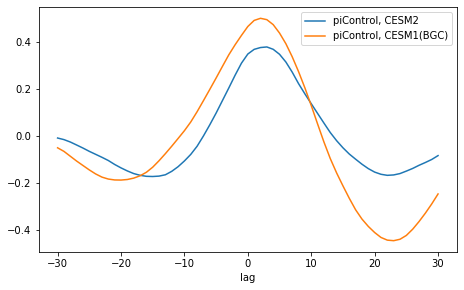

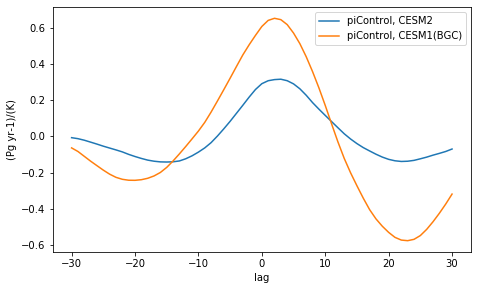

In [5]:
corr_anal(('TS', 'SFCO2_LND'), ['piControl', 'piControl-cmip5'], region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=SFCO2_LND, region_y=Global


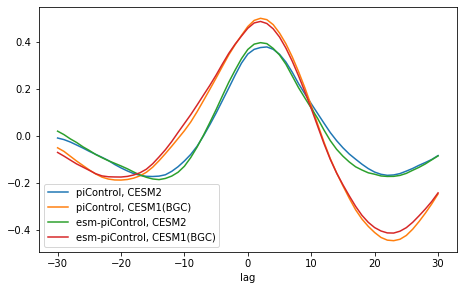

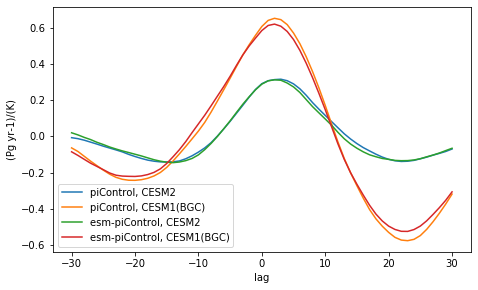

In [6]:
corr_anal(('TS', 'SFCO2_LND'), ['piControl', 'piControl-cmip5', 'esm-piControl', 'esm-piControl-cmip5'], region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=GPP, region_y=Global


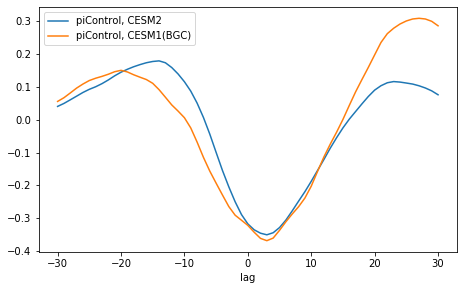

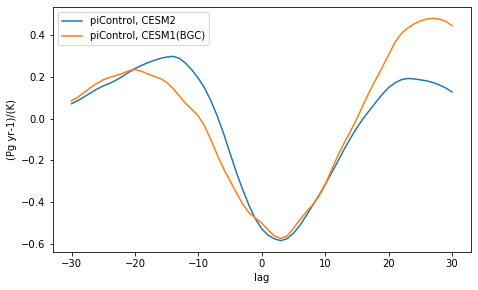

In [7]:
corr_anal(('TS', 'GPP'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=NPP, region_y=Global


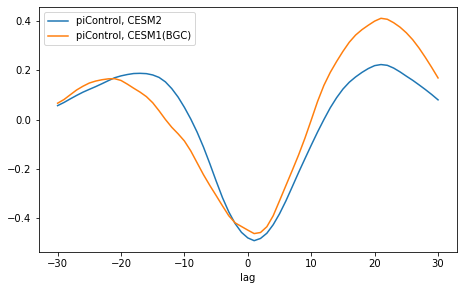

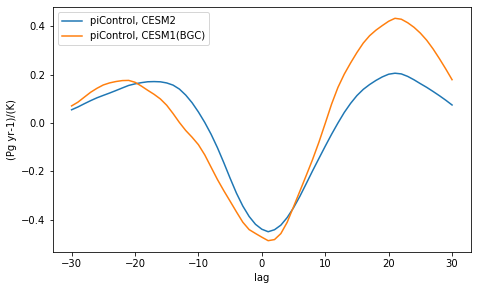

In [8]:
corr_anal(('TS', 'NPP'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=AR, region_y=Global


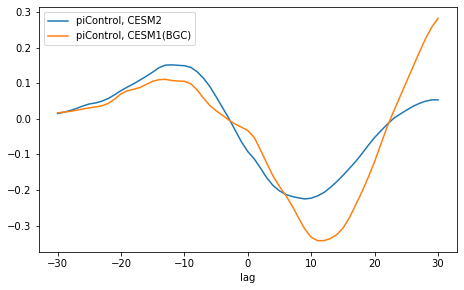

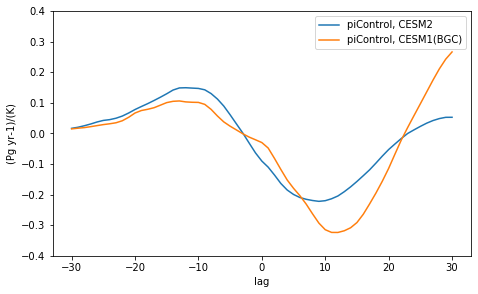

In [9]:
corr_anal(('TS', 'AR'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), region_x='nino34', ylim=(-.4,.4))

varname_x=TS, region_x=nino34, varname_y=TOTVEGC, region_y=Global


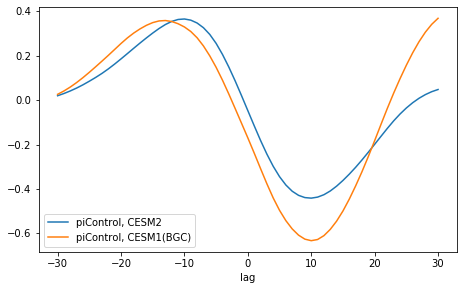

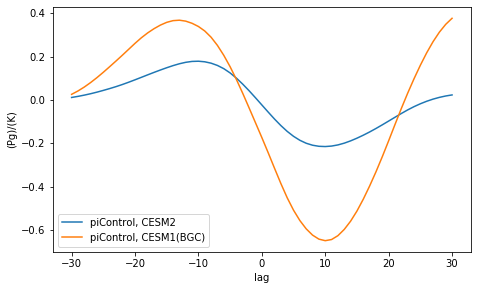

In [10]:
corr_anal(('TS', 'TOTVEGC'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=HR, region_y=Global


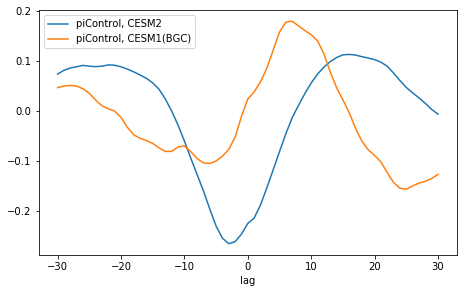

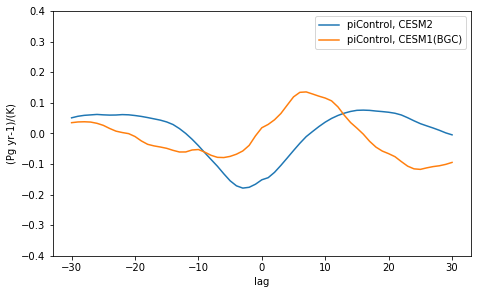

In [11]:
corr_anal(('TS', 'HR'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), region_x='nino34', ylim=(-.4,.4))

varname_x=TS, region_x=nino34, varname_y=TOTSOMC, region_y=Global


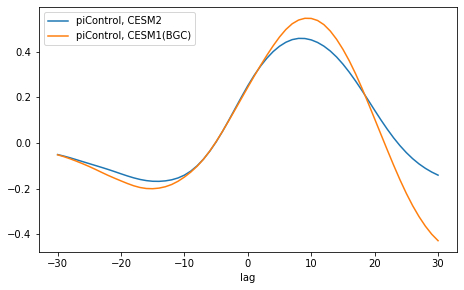

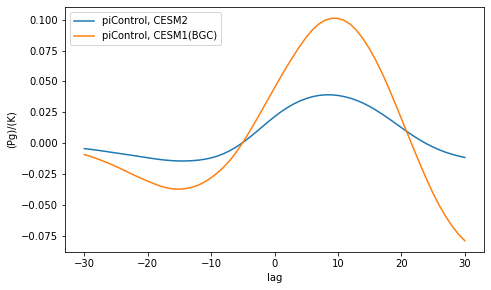

In [12]:
corr_anal(('TS', 'TOTSOMC'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), region_x='nino34')

varname_x=TS, region_x=nino34, varname_y=ER, region_y=Global


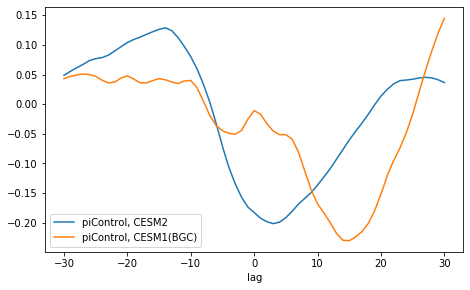

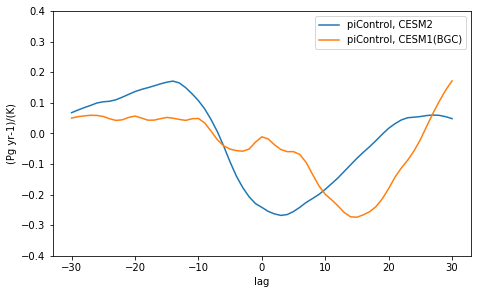

In [13]:
corr_anal(('TS', 'ER'), ['piControl', 'piControl-cmip5'], component_pair=('atm', 'lnd'), region_x='nino34', ylim=(-.4,.4))